In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud
import random

In [4]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import requests
 
subreddit = 'android'
limit = 100
timeframe = 'year' #hour, day, week, month, year, all
listing = 'top' # controversial, best, hot, new, random, rising, top
 
def get_reddit(subreddit,listing,limit,timeframe):
    try:
        base_url = f'https://www.reddit.com/r/{subreddit}/{listing}.json?limit={limit}&t={timeframe}'
        request = requests.get(base_url, headers = {'User-agent': 'yourbot'})
    except:
        print('An Error Occured')
    return request.json()
 
r = get_reddit(subreddit,listing,limit,timeframe)

In [32]:
def get_post_info(r):
    posts = {}
    for post in r['data']['children']:
        posts[post['data']['title']] = {'score':post['data']['score'],'comments':post['data']['num_comments'], 'gilded': post['data']['gilded']}
    return posts
 
posts = get_post_info(r)
print(len(posts))

100


In [36]:
print(list(posts.keys())[0])

LG to close mobile phone business worldwide


In [31]:
print(posts[0][1])

0.97


In [53]:
#titles = list(posts)
df = pd.DataFrame(posts.keys(), columns=['title'])
df = df.join(pd.DataFrame(posts.values(), columns= ['score', 'gilded']))
df.head()

,title,score,gilded
0,LG to close mobile phone business worldwide,10077,0
1,Apple declined iMessage for Android in order t...,9439,0
2,Google said it was a “problem” to give android...,8946,0
3,"[MKBHD] ""My Pixel 6 Pro has slowly gotten so b...",8238,0
4,WhatsApp will progressively kill features unti...,7945,0


In [54]:
sid = SentimentIntensityAnalyzer()

In [55]:
res = [*df['title'].apply(sid.polarity_scores)]
print(res[:3])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.5859}]


In [56]:
sentiment_df = pd.DataFrame.from_records(res)
df = pd.concat([df, sentiment_df], axis=1, join='inner')
df.head()

,title,score,gilded,neg,neu,pos,compound
0,LG to close mobile phone business worldwide,10077,0,0.000,1.000,0.000,0.0000
1,Apple declined iMessage for Android in order t...,9439,0,0.000,1.000,0.000,0.0000
2,Google said it was a “problem” to give android...,8946,0,0.000,0.789,0.211,0.5859
3,"[MKBHD] ""My Pixel 6 Pro has slowly gotten so b...",8238,0,0.116,0.833,0.051,-0.4939
4,WhatsApp will progressively kill features unti...,7945,0,0.258,0.604,0.137,-0.4939


In [57]:
THRESHOLD = 0.1

conditions = [
    (df['compound'] <= -THRESHOLD),
    (df['compound'] > -THRESHOLD) & (df['compound'] < THRESHOLD),
    (df['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
df['label'] = np.select(conditions, values)

df.head()

,title,score,gilded,neg,neu,pos,compound,label
0,LG to close mobile phone business worldwide,10077,0,0.000,1.000,0.000,0.0000,neu
1,Apple declined iMessage for Android in order t...,9439,0,0.000,1.000,0.000,0.0000,neu
2,Google said it was a “problem” to give android...,8946,0,0.000,0.789,0.211,0.5859,pos
3,"[MKBHD] ""My Pixel 6 Pro has slowly gotten so b...",8238,0,0.116,0.833,0.051,-0.4939,neg
4,WhatsApp will progressively kill features unti...,7945,0,0.258,0.604,0.137,-0.4939,neg


In [58]:
df.label.value_counts()

neu    49
pos    28
neg    23
Name: label, dtype: int64

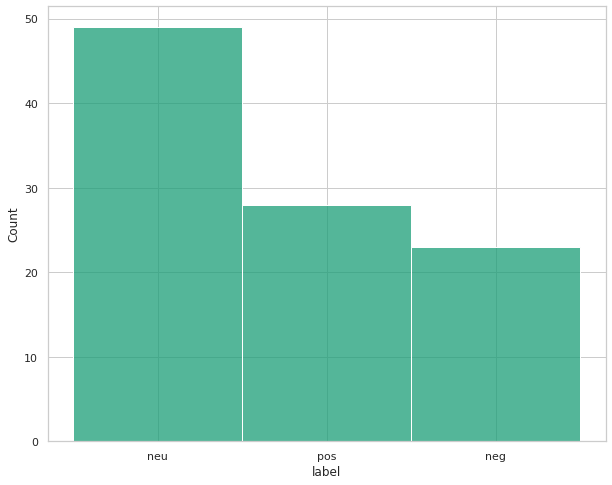

In [59]:
sns.histplot(df.label);

In [60]:
def df_title_output(sub, label):
  res = sub[sub['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
df_sub = df.groupby('label').sample(n = 5, random_state = 7)

print("Positive posts")
df_title_output(df_sub, "pos")

print("\nNeutral posts")
df_title_output(df_sub, "neu")

print("\nNegative posts")
df_title_output(df_sub, "neg")

Positive posts
Proof that snaps from Snapchat don't disappear and can easily be recovered on Android
MAGA-branded ‘Freedom Phone’ Is a Major Security Hazard
Spotify launches lyrics feature globally for free and paying users
Sony's Xperia division apparently turned a profit for the first time in years
Apps with 5.8 million Google Play downloads stole users’ Facebook passwords

Neutral posts
IBM and Samsung say their new chip design could lead to week-long battery life on phones
Microsoft is bringing Android apps to Windows 11
Since enabling two-factor authentication, Google account hacks have dropped 50%
Google will finally let file manager apps request “All Files Access” on Android 11 next month
Make Android devices faster with Universal Android Debloater. It now has a GUI and more options!

Negative posts
WhatsApp will progressively kill features until users agree to the new privacy policy
OnePlus Watch Review: The Worst Smartwatch I've Ever Used
Why Apple doesn't care that a quarter 

In [61]:
stop_words = stopwords.words('english')
print(len(stop_words))

179


In [62]:
def custom_tokenize(text):
  # remove single quote and dashes
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

In [63]:
from itertools import chain 
def tokens_2_words(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(df, 'pos')
neg_words = tokens_2_words(df, 'neg')

In [64]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('google', 13),
 ('android', 9),
 ('play', 5),
 ('users', 4),
 ('one', 4),
 ('years', 4),
 ('store', 4),
 ('security', 3),
 ('6', 3),
 ('new', 3),
 ('working', 3),
 ('nothing', 3),
 ('easier', 2),
 ('phone', 2),
 ('major', 2),
 ('better', 2),
 ('use', 2),
 ('pixel', 2),
 ('chip', 2),
 ('twitter', 2)]

In [65]:
def pos_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(120, {0}%, {0}%)".format(random.randint(60, 100), random.randint(30, 45))

In [66]:
def neg_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, {0}%, {0}%)".format(random.randint(60, 100), random.randint(30, 45))

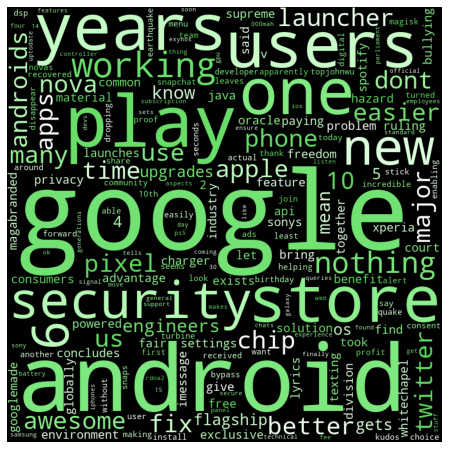

In [67]:
wc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(pos_freq)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc.recolor(color_func=pos_color_func, random_state=3))
plt.axis("off")
 
plt.show()

In [68]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

[('google', 7),
 ('new', 6),
 ('users', 5),
 ('android', 5),
 ('samsung', 4),
 ('pro', 3),
 ('oneplus', 3),
 ('play', 3),
 ('store', 3),
 ('app', 3),
 ('pixel', 2),
 ('6', 2),
 ('review', 2),
 ('policy', 2),
 ('kills', 2),
 ('galaxy', 2),
 ('pay', 2),
 ('ads', 2),
 ('starting', 2),
 ('today', 2)]

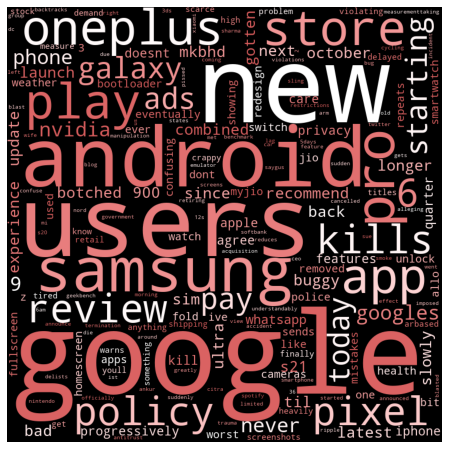

In [69]:
wc = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(neg_freq)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc.recolor(color_func=neg_color_func, random_state=3))
plt.axis("off")
 
plt.show()